In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from scipy.stats import entropy
import copy
import math
import os



In [41]:
def count_alphabets(input_string):
    """
    Calculate the total number of alphabets and the number of unique alphabets in the input string.

    Parameters:
    input_string (str): The string to analyze.

    Returns:
    tuple: A tuple containing the total number of alphabets and the number of unique alphabets.
    """
    total_alphabets = len(input_string)
    unique_alphabets = len(set(input_string))
    
    return total_alphabets, unique_alphabets

# Example usage
input_string = "TGDCABCDEFGHIRSTABCDEFGHIJKLMNOPQRSTIJKLMNOPJKGDEFGBCDEFGHIJKLEFGHIJKLMNOPQLMNOPQRSTABCDEFGHITERJKLMNOPABCDEFGHPQRHIJKLMNOPQRSTABCDEFGHIJKLEFGHIJKLMCDEFGHIJKDEFGHIJKLMNOPQRSTABCDNOPQRSLMNOPQRSTABCTANJ"
total, unique = count_alphabets(input_string)

print(f"Total number of alphabets: {total}")
print(f"Number of unique alphabets: {unique}")


Total number of alphabets: 200
Number of unique alphabets: 20


In [24]:
import numpy

def getTrainingData(songStrings, nrOfSongs):
    # Extended to 20 alphabets
    notes = list("ABCDEFGHIJKLMNOPQRST")
    chord = [[i] for i in range(len(notes))]  # Simplified generation of chords based on notes index
    print(chord)
    source = []
    target = []
    song = []
    
    for s in range(nrOfSongs):
        for i in range(200):  # Updated to 162 to account for the longer song strings
            sentence = []
            answer = []
            song.append(s)
            for j in range(200):  # Updated to 161 to match the new song length requirement
                # Updated modulo operation to match the new length
                sentence.append(chord[notes.index(songStrings[s][(i+j) % 200])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1) % 200])][0])
            source.append(sentence)
            target.append(answer)
    return numpy.array(source), numpy.array(target), numpy.array(song)

# Update your songStrings with longer strings, each extended to 162 characters
songStrings = numpy.array([
    "CKGGAAMFFEEDDCGGFTEEDGGFFLEDCCGGAAIFJEEOCKGGAAMFEEDGGFFLEDCTEEDGGFFLEDCCGGAAIOCKMGGAAMFFECNKGGAAMFFEAIOFJEEOEEEEDDCGGFTPEEDGGFFLEDCCGGAAIFJEDGGFFLEDCCGGAAIFJEEOCKGGAAMFFEEDDCGGFTEEDGGFFLEDCCGGAAIFJEEO",
    "ABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRST"  # Example extension
       # Example extension
    # Add or modify additional songs as needed, ensuring each is 162 characters long
])

source, target, song = getTrainingData(songStrings, 2)
print(source.shape, target.shape, song.shape)


[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
(400, 200) (400, 200) (400,)


In [42]:
import numpy as np

def getTrainingData(songStrings, nrOfSongs):
    # Extended to 20 alphabets
    notes = list("ABCDEFGHIJKLMNOPQRST")
    chord = [[i] for i in range(len(notes))]  # Simplified generation of chords based on notes index
    print(chord)
    source = []
    target = []
    song = []
    
    for s in range(nrOfSongs):
        for i in range(200):  # Updated to 162 to account for the longer song strings
            sentence = []
            answer = []
            song.append(s)
            for j in range(200):  # Updated to 161 to match the new song length requirement
                # Updated modulo operation to match the new length
                sentence.append(chord[notes.index(songStrings[s][(i+j) % 200])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1) % 200])][0])
            source.append(sentence)
            target.append(answer)
    return numpy.array(source), numpy.array(target)

def split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction):
    total_rows = source.shape[0] // 2
    first_set_rows = int(total_rows * fraction)
    second_set_rows = total_rows - first_set_rows

    first_set_indices = np.random.choice(range(total_rows), first_set_rows, replace=False)
    second_set_indices = np.random.choice(range(total_rows, 2 * total_rows), second_set_rows, replace=False)

    combined_indices = np.concatenate((first_set_indices, second_set_indices))
    np.random.shuffle(combined_indices)

    input_list = source[combined_indices]
    output_list = target[combined_indices]

    return input_list, output_list

# Data generation and preparation
songStrings = np.array([
    "CKGGAAMFFEEDDCGGFTEEDGGFFLEDCCGGAAIFJEEOCKGGAAMFEEDGGFFLEDCTEEDGGFFLEDCCGGAAIOCKMGGAAMFFECNKGGAAMFFEAIOFJEEOEEEEDDCGGFTPEEDGGFFLEDCCGGAAIFJEDGGFFLEDCCGGAAIFJEEOCKGGAAMFFEEDDCGGFTEEDGGFFLEDCCGGAAIFJEEO",
    "TGDCABCDEFGHIRSTABCDEFGHIJKLMNOPQRSTIJKLMNOPJKGDEFGBCDEFGHIJKLEFGHIJKLMNOPQLMNOPQRSTABCDEFGHITERJKLMNOPABCDEFGHPQRHIJKLMNOPQRSTABCDEFGHIJKLEFGHIJKLMCDEFGHIJKDEFGHIJKLMNOPQRSTABCDNOPQRSLMNOPQRSTABCTANJ"  # Example extension
])

source_mixed, target_mixed = getTrainingData(songStrings, 2)
fraction = 0.5
input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source_mixed, target_mixed, fraction)

print(input_list.shape, output_list.shape)


[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
(200, 200) (200, 200)


In [43]:
# Simulating the I and O arrays with random data for demonstration

# Flattening and printing I and O arrays
for i in range(200):
    print(f"I[{i}].flatten(): {input_list[i].flatten()}, O[{i}].flatten(): {output_list[i].flatten()}")

# Checking the size of O and I
I_sizes = [arr.size for arr in input_list]
O_sizes = [arr.size for arr in output_list]
I_sizes, O_sizes

I[0].flatten(): [ 9 10  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3 13
 14 15 16 17 18 11 12 13 14 15 16 17 18 19  0  1  2 19  0 13  9 19  6  3
  2  0  1  2  3  4  5  6  7  8 17 18 19  0  1  2  3  4  5  6  7  8  9 10
 11 12 13 14 15 16 17 18 19  8  9 10 11 12 13 14 15  9 10  6  3  4  5  6
  1  2  3  4  5  6  7  8  9 10 11  4  5  6  7  8  9 10 11 12 13 14 15 16
 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7  8 19  4 17  9 10 11
 12 13 14 15  0  1  2  3  4  5  6  7 15 16 17  7  8  9 10 11 12 13 14 15
 16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11  4  5  6  7  8  9 10 11
 12  2  3  4  5  6  7  8], O[0].flatten(): [10  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3 13 14
 15 16 17 18 11 12 13 14 15 16 17 18 19  0  1  2 19  0 13  9 19  6  3  2
  0  1  2  3  4  5  6  7  8 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19  8  9 10 11 12 13 14 15  9 10  6  3  4  5  6  1
  2  3  4  5  6  7  8  9 10 11  4  5  6  7  8  9 10 11 12 13 14 1

([200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,
  200,

In [27]:
class TransformerModel(nn.Module):
    def __init__(self, ntokens, emsize, nhead, d_hid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        encoder_layers = nn.TransformerEncoderLayer(emsize, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntokens, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, ntokens)
        self.ntokens=ntokens
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src,verbose=False):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        self.store=output.detach().numpy().copy()
        if verbose:
            print(output.shape)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Parameters
ntokens = 20  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.03  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
print(model)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.03, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
        )
        (linear1): Linear(in_features=20, out_features=20, bias=True)
        (dropout): Dropout(p=0.03, inplace=False)
        (linear2): Linear(in_features=20, out_features=20, bias=True)
        (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.03, inplace=False)
        (dropout2): Dropout(p=0.03, inplace=False)
      )
    )
  )
  (encoder): Embedding(20, 20)
  (decoder): Linear(in_features=20, out_features=20, bias=True)
)


In [28]:
def test(model, source, target):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source.transpose(0, 1)  # Adjust for the expected input dimensions [sequence_length, batch_size]
        tgt = target.transpose(0, 1)  # Same adjustment for the target
        
        output = model(src)  # Compute the output
        
        # The output is [sequence_length, batch_size, ntokens]. Get the most likely token predictions
        predictions = output.argmax(dim=2)  # Get the index of the max log-probability
        
        correct += (predictions == tgt).sum().item()  # Count how many predictions match the target
        total += tgt.numel()  # Total number of predictions
        
    accuracy = correct / total  # Calculate the accuracy
    return accuracy

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
Epoch 1, Loss: 0.0151
acc: 0.044775


/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_56816/550002729.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_56816/550002729.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Epoch 101, Loss: 0.0109
acc: 0.59985
Epoch 201, Loss: 0.0063
acc: 0.843325
Epoch 301, Loss: 0.0040
acc: 0.85715
Epoch 401, Loss: 0.0029
acc: 0.8671
Epoch 501, Loss: 0.0023
acc: 0.874275
Epoch 601, Loss: 0.0017
acc: 0.895275
Epoch 701, Loss: 0.0014
acc: 0.915425
Epoch 801, Loss: 0.0011
acc: 0.92875
Epoch 901, Loss: 0.0010
acc: 0.941275
Epoch 1001, Loss: 0.0008
acc: 0.951925
Epoch 1101, Loss: 0.0007
acc: 0.96035
Epoch 1201, Loss: 0.0006
acc: 0.966025
Epoch 1301, Loss: 0.0006
acc: 0.970525
Epoch 1401, Loss: 0.0005
acc: 0.974825
Epoch 1501, Loss: 0.0004
acc: 0.9796
Epoch 1601, Loss: 0.0004
acc: 0.98305
Epoch 1701, Loss: 0.0003
acc: 0.985325
Epoch 1801, Loss: 0.0003
acc: 0.9868
Epoch 1901, Loss: 0.0003
acc: 0.987925
Model saved at two transformers models/model_at_fraction_0.00.pt
Epoch 1, Loss: 0.0151
acc: 0.046875
Epoch 101, Loss: 0.0113
acc: 0.4223
Epoch 201, Loss: 0.0078
acc: 0.7091
Epoch 301, Loss: 0.0057
acc: 0.738425
Epoch 401, Loss: 0.0047
acc: 0.750725
Epoch 501, Loss: 0.0041
acc: 0

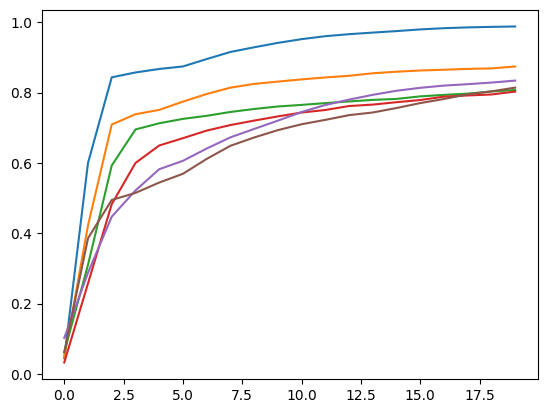

In [44]:
# Define the fractions
fractions = np.arange(0, 101, 20) / 100

# Initialize parameters for the model
ntokens = 20  # size of vocabulary
emsize = 10  # embedding dimension
nhead = 2  # number of heads in the nn.MultiheadAttention
d_hid = 10  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.03  # dropout probability
learning_rate = 1e-3
num_epochs = 2000

model_dir = "two transformers models"
os.makedirs(model_dir, exist_ok=True)

source, target = getTrainingData(songStrings, 2)

for fraction in fractions:

    model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

    W=[]
    model.train()  # Set the model to training mode
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

    for epoch in range(num_epochs):
        total_loss = 0
        
        # Here, we assume batching is handled externally, and source is directly fed into the model
        optimizer.zero_grad()  # Clear the gradients of all optimized tensors
        
        source_tensor = torch.tensor(input_list, dtype=torch.long)
        target_tensor = torch.tensor(output_list, dtype=torch.long)

        # Adjust for PyTorch expecting (sequence_length, batch_size), so we transpose source and target
        src = source_tensor.transpose(0, 1)  # Now shape [41, sentences]
        tgt = target_tensor.transpose(0, 1)  # Now shape [41, sentences]
        
        output = model(src)  # Forward pass: compute the output of the model
        
        # Output is [sequence_length, batch_size, ntokens], target is [sequence_length, batch_size]
        # Flatten output to [sequence_length*batch_size, ntokens] for compatibility with CrossEntropyLoss
        output_flat = output.view(-1, model.ntokens)
        tgt_flat = tgt.reshape(-1)
        
        loss = criterion(output_flat, tgt_flat)  # Compute the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
        
        total_loss += loss.item()
        
        avg_loss = total_loss / src.size(1)  # average loss per sentence

        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            
            W.append(test(model,source_tensor,target_tensor))

            print("acc:",W[-1])
        
        input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

    plot(W)

    model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')

    torch.save(model.state_dict(), model_save_path)
    
    print(f"Model saved at {model_save_path}")


In [45]:
test(model,torch.tensor(source),torch.tensor(target))

/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_56816/550002729.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_56816/550002729.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


0.43875

In [46]:

fractions = np.arange(0, 101, 20) / 100
accuracies = []

model_dir = "two transformers models"

source, target = getTrainingData(songStrings, 2)

model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

for fraction in fractions:

    model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
    model.load_state_dict(torch.load(model_path))   
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0

    input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)
    source_tensor = torch.tensor(input_list, dtype=torch.long)
    target_tensor = torch.tensor(output_list, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source_tensor.transpose(0, 1)  # Adjust for the expected input dimensions [sequence_length, batch_size]
        tgt = target_tensor.transpose(0, 1)  # Same adjustment for the target

        output = model(src)  # Compute the output
        predictions = output.argmax(dim=2)  # Get the index of the max log-probability

        correct += (predictions == tgt).sum().item()  # Count how many predictions match the target
        total += tgt.numel()  # Total number of predictions

    accuracy = correct / total  # Calculate the accuracy
    accuracies.append(accuracy)  # Collect accuracies for each fraction

# After the loop, you might want to print or return the collected accuracies.
for frac, acc in zip(fractions, accuracies):
    print(f"Fraction: {frac}, Accuracy: {acc}")

# If you want to return the accuracies from a function, just return the 'accuracies' list.


[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
Fraction: 0.0, Accuracy: 0.989
Fraction: 0.2, Accuracy: 0.874125
Fraction: 0.4, Accuracy: 0.809725
Fraction: 0.6, Accuracy: 0.81035
Fraction: 0.8, Accuracy: 0.837075
Fraction: 1.0, Accuracy: 0.82485


In [32]:
def test_data(source, target, fraction):
    total_rows = source.shape[0] // 2
    first_set_rows = int(total_rows * fraction)
    second_set_rows = total_rows - first_set_rows

    first_set_indices = np.random.choice(range(total_rows), first_set_rows, replace=False)
    second_set_indices = np.random.choice(range(total_rows, 2 * total_rows), second_set_rows, replace=False)

    combined_indices = np.concatenate((first_set_indices, second_set_indices))
    np.random.shuffle(combined_indices)

    input_list = source[combined_indices]
    output_list = target[combined_indices]

    return input_list, output_list

In [49]:

fractions = np.arange(0, 101, 20) / 100

# Define a directory to save/load models
model_dir = "long transformers models"

# Assuming getTrainingData and split_and_shuffle_data_randomly_based_on_fraction are defined as before

# Load the song strings
songStrings = np.array([
    # "CKGGAAMFFEEDDCGGFTEEDGGFFLEDCCGGAAIFJEEOCKGGAAMFEEDGGFFLEDCTEEDGGFFLEDCCGGAAIOCKMGGAAMFFECNKGGAAMFFEAIOFJEEOEEEEDDCGGFTPEEDGGFFLEDCCGGAAIFJEDGGFFLEDCCGGAAIFJEEOCKGGAAMFFEEDDCGGFTEEDGGFFLEDCCGGAAIFJEEO",
    # "ABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRSTABCDEFGHIJKLMNOPQRST"  
 "CKGGAAMFFEEDDCGGFTEEDGGFFLEDCCGGAAIFJEEOCKGGAAMFEEDGGFFLEDCTEEDGGFFLEDCCGGAAIOCKMGGAAMFFECNKGGAAMFFEAIOFJEEOEEEEDDCGGFTPEEDGGFFLEDCCGGAAIFJEDGGFFLEDCCGGAAIFJEEOCKGGAAMFFEEDDCGGFTEEDGGFFLEDCCGGAAIFJEEO",
 "TGDCABCDEFGHIRSTABCDEFGHIJKLMNOPQRSTIJKLMNOPJKGDEFGBCDEFGHIJKLEFGHIJKLMNOPQLMNOPQRSTABCDEFGHITERJKLMNOPABCDEFGHPQRHIJKLMNOPQRSTABCDEFGHIJKLEFGHIJKLMCDEFGHIJKDEFGHIJKLMNOPQRSTABCDNOPQRSLMNOPQRSTABCTANJ"  # Example extension

])

# Initialize the model parameters here (ntokens, emsize, etc.), same as during training
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

accuracies = np.zeros((len(fractions), len(songStrings))) 
 # For storing accuracies of each song at each fraction
for frac_idx, fraction in enumerate(fractions):

    for song_idx, song in enumerate(songStrings):
        
        source, target = getTrainingData(np.array([song]), 1)  # Get data for the current song

        # for frac_idx, fraction in enumerate(fractions):

        model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        model.load_state_dict(torch.load(model_path))
        model.eval()  # Set the model to evaluation mode

        correct = 0
        total = 0

        # input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)
        # source_tensor = torch.tensor(input_list, dtype=torch.long)
        # target_tensor = torch.tensor(output_list, dtype=torch.long)

        source_tensor = torch.tensor(source, dtype=torch.long)
        target_tensor = torch.tensor(target, dtype=torch.long)

        with torch.no_grad():
            
            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            predictions = output.argmax(dim=2)

            correct += (predictions == tgt).sum().item()
            total += tgt.numel()

        accuracy = correct / total
        accuracies[frac_idx, song_idx] = accuracy  # Store accuracy for this song at this fraction

# Print or process the accuracies array as needed
for song_idx, song in enumerate(songStrings):
    print(f"Accuracies for song {song_idx}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"Fraction: {fraction}, Accuracy: {accuracies[frac_idx, song_idx]}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19]]
[

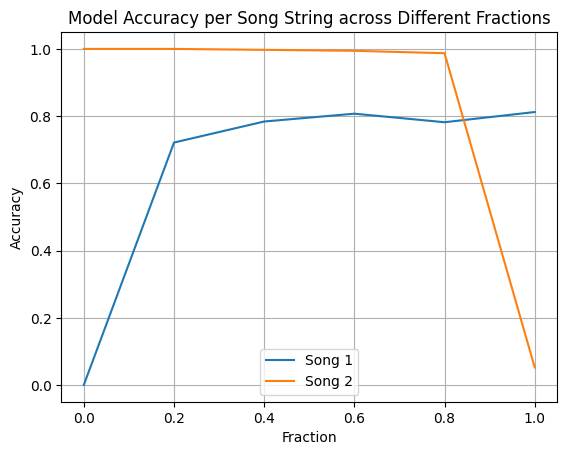

In [37]:
import matplotlib.pyplot as plt

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions')
plt.legend()
plt.grid(True)
plt.show()


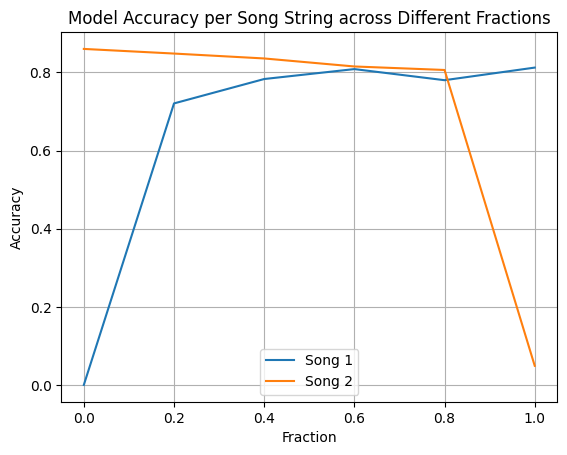

In [48]:
import matplotlib.pyplot as plt

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions')
plt.legend()
plt.grid(True)
plt.show()


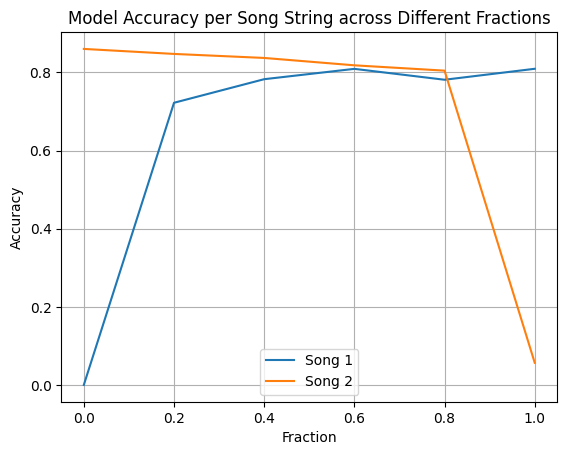

In [50]:
import matplotlib.pyplot as plt

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions')
plt.legend()
plt.grid(True)
plt.show()
